In [1]:
import os
os.chdir('../../')

In [3]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets as datasets
from models import cmlp
from utilities import fits
from flax import linen as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
from utilities.plot import plot_binary_class
import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
from functools import partial
from jax.flatten_util import ravel_pytree
import blackjax
from probml_utils.blackjax_utils import inference_loop
from sklearn.calibration import calibration_curve,CalibrationDisplay

2022-07-02 11:38:00.562832: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


# Dataset Visualization

In [4]:
X,Y =  datasets.make_moons(1000, noise=0.20,random_state=6)

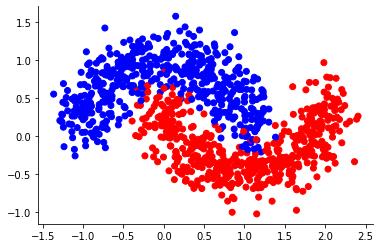

In [5]:
plt.scatter(X[:,0],X[:,1],c=Y,cmap="bwr")
sns.despine()

In [6]:
h=0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, h),
                     jnp.arange(y_min, y_max, h))

In [7]:
xx.shape

(92, 116)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.5, random_state=45)

In [9]:
X_train = jnp.array(X_train)
X_test = jnp.array(X_test)
y_train = jnp.array(y_train)
y_test = jnp.array(y_test)


# Single MLP

In [10]:
model = cmlp.cmlp([8,16,32,16,8,1],[nn.relu,nn.relu,nn.relu,nn.relu,nn.relu],[0.03]*5)

In [11]:
auxs = {
    "X" : X_train,
    "y" : y_train,
    "deterministic": True,
}

## Train

In [12]:
seed=0
params = model.init(jax.random.PRNGKey(seed), X_train, deterministic = True)
params, loss =  fits.fit(model, params,X_train,y_train,True,learning_rate=0.01, epochs=1000,batch_size=64)

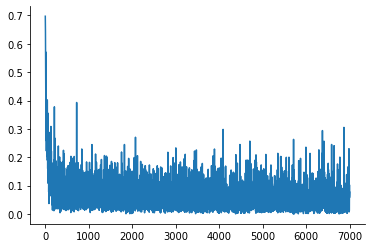

In [13]:
plt.plot(jnp.arange(0,loss.shape[0],1),loss)
sns.despine()

In [14]:
y_pred_train = model.apply(params, X_train, deterministic=True)
y_pred_test = model.apply(params, X_test, deterministic=True)

In [15]:
def plot_caliberation_classification(pred_train,pred_test,title):
    fig,ax1 = plt.subplots(1,1)
    prob_true_train,prob_pred_train = calibration_curve(y_train,pred_train,n_bins=5)
    prob_true_test,prob_pred_test = calibration_curve(y_test,pred_test)

    disp_train = CalibrationDisplay(prob_true_train,prob_pred_train,pred_train,estimator_name="Train")
    disp_test = CalibrationDisplay(prob_true_test,prob_pred_test,pred_test,estimator_name="Test",)

    disp_train.plot(ax=ax1)
    disp_test.plot(ax=ax1)
    sns.despine(ax=ax1)
    ax1.legend(loc=0)
    ax1.set_title(title)

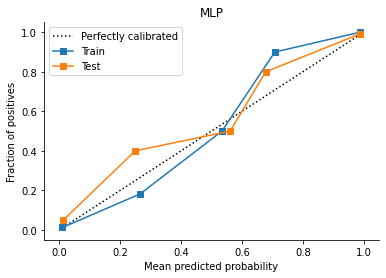

In [16]:
mlp_pred_train = model.apply(params,X_train,deterministic=True).reshape(y_train.shape)
mlp_pred_test = model.apply(params,X_test,deterministic=True).reshape(y_test.shape)
plot_caliberation_classification(mlp_pred_train,mlp_pred_test,"MLP")
#plt.savefig("MLP_caliberation.pdf")

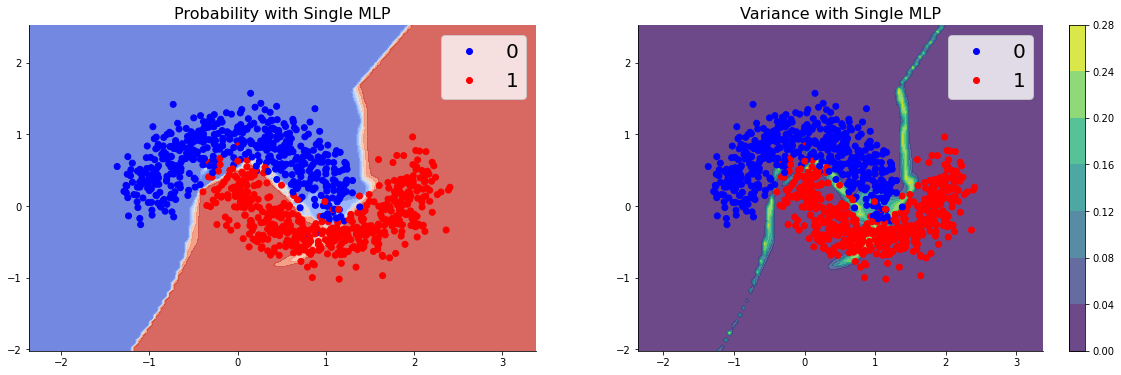

In [17]:
p =model.apply(params,jnp.c_[xx.ravel(), yy.ravel()],deterministic=True).reshape(xx.shape)
var = p*(1-p).reshape(xx.shape)

plot_binary_class(X,Y,xx,yy,p,var,titles=("Probability with Single MLP","Variance with Single MLP"))
# #plt.savefig("figures/mlp_moons.pdf")
#plt.savefig("MLP_moons.pdf")

# Deep Ensemble

In [18]:
params_lst= []
loss_lst =[]
for i in range(5):
    params =  model.init(jax.random.PRNGKey(i),X,deterministic=True)
    params,loss = fits.fit(model, params,X_train,y_train,True,learning_rate=0.01, epochs=100)
    params_lst.append(params)
    loss_lst.append(loss)

In [19]:
p_de_train_ensemble = []
p_de_test_ensemble = []

for i in range(5):
    params = params_lst[i]
    p =model.apply(params,X_train,deterministic=True)
    p_de_train_ensemble.append(p)
    p =model.apply(params,X_test,deterministic=True)
    p_de_test_ensemble.append(p)
ensemble_pred_train = jnp.array(p_de_train_ensemble).mean(axis=0).reshape(y_train.shape)
ensemble_pred_test= jnp.array(p_de_test_ensemble).mean(axis=0).reshape(y_test.shape)

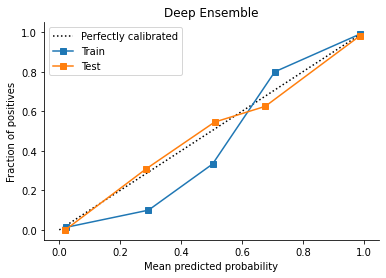

In [20]:
plot_caliberation_classification(ensemble_pred_train,ensemble_pred_test,title="Deep Ensemble")
#plt.savefig("Deep Ensemble caliberation.pdf")

In [21]:
p_grid_ensemble = []

for i in range(5):
    params = params_lst[i]
    p =  model.apply(params,jnp.c_[xx.ravel(), yy.ravel()],deterministic=True).reshape(xx.shape)
    p_grid_ensemble.append(p)
ensemble_p_mean = jnp.array(p_grid_ensemble).mean(axis=0)
# ensemble_p_sigma =  jnp.array(p_grid_ensemble).std(axis=0)
ensemble_p_sigma = jnp.sqrt(ensemble_p_mean*(1-ensemble_p_mean))


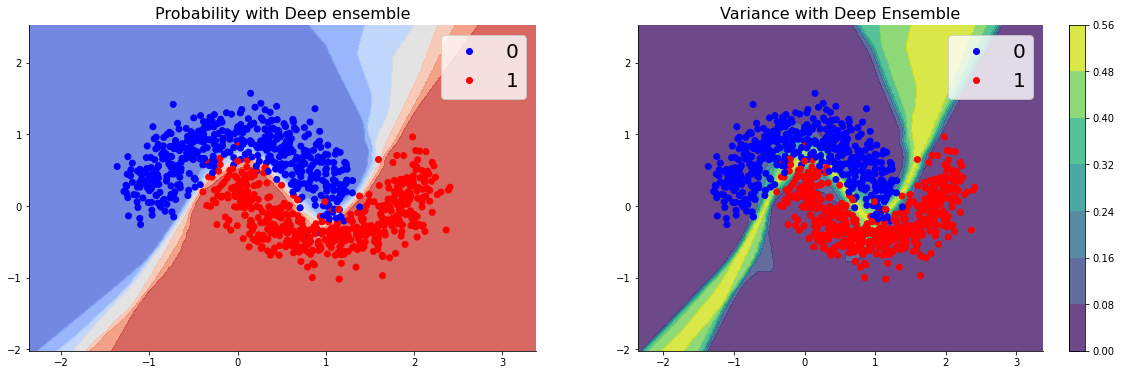

In [22]:
plot_binary_class(X,Y,xx,yy,ensemble_p_mean,ensemble_p_sigma,titles=("Probability with Deep ensemble","Variance with Deep Ensemble"))
#plt.savefig("Deep Ensemble Moons.pdf")

### MC Dropout

In [23]:
y_stacks = []

@jax.jit
def func(params, i):
    z = model.apply(params, jnp.c_[xx.ravel(), yy.ravel()], deterministic=False, 
                    rngs={"dropout": jax.random.PRNGKey(i)}).reshape(xx.shape)
    return z
y_stacks = jax.vmap(fun=func, in_axes=(None, 0))(params, jnp.arange(50))

In [24]:
mc_pred_mean= jnp.array(y_stacks).mean(axis=0).reshape(xx.shape)
mc_pred_sigma = (jnp.array(y_stacks).std(axis=0)).reshape(yy.shape)

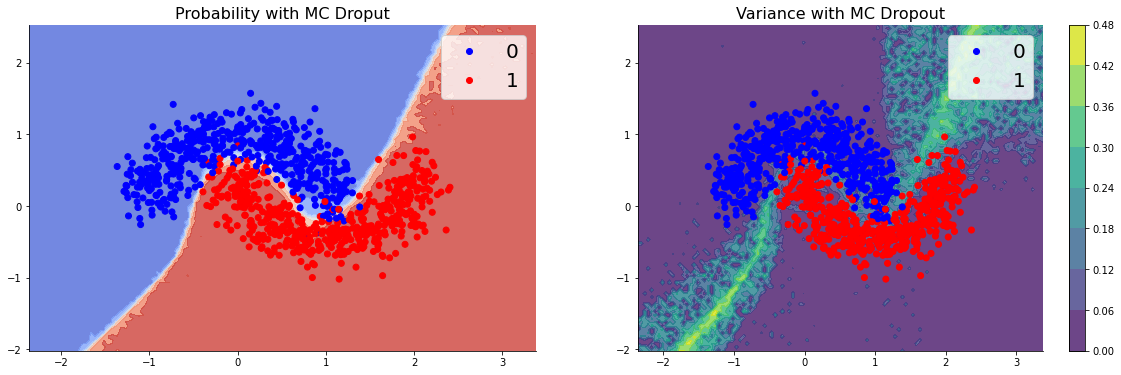

In [25]:
plot_binary_class(X,Y,xx,yy,mc_pred_mean,mc_pred_sigma,titles=("Probability with MC Droput","Variance with MC Dropout"))
#plt.savefig("MC Dropout Moons.pdf")

In [26]:
y_stacks_train = []
y_stacks_test = []


def create_apply_func(X_test):
    def func(params, i):
        z = model.apply(params, X_test, deterministic=False, 
                        rngs={"dropout": jax.random.PRNGKey(i)})
        return z
    return func
y_stacks_train = jax.vmap(fun=create_apply_func(X_train), in_axes=(None, 0))(params, jnp.arange(50))
y_stacks_test = jax.vmap(fun=create_apply_func(X_test), in_axes=(None, 0))(params, jnp.arange(50))


In [27]:
mc_pred_train = y_stacks_train.mean(axis=0)
mc_pred_test = y_stacks_test.mean(axis=0)

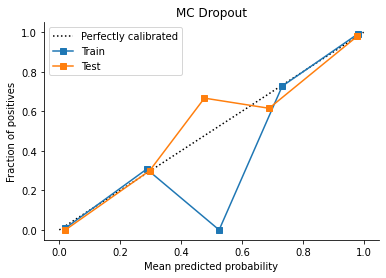

In [28]:
plot_caliberation_classification(mc_pred_train,mc_pred_test,"MC Dropout")
#plt.savefig("MC_dropout_caliberation.pdf")

### Bootstrap

In [29]:
num_bootstraps = 10
params_list=[]
loss_list=[]
keys = jax.random.split(jax.random.PRNGKey(0),num_bootstraps)
for i in range(num_bootstraps):
    ids = jax.random.choice(keys[i], jnp.array(range(len(X))), (len(X),))
    x, y = X_train[ids], y_train[ids]
    params =  model.init(jax.random.PRNGKey(i),x,deterministic=True)
    params,loss = fits.fit(model, params, x, y, True, batch_size=len(x), learning_rate=0.01, epochs=100)
    params_list.append(params) 
    loss_list.append(loss)

In [30]:
bs_train = []
bs_test = []

for i in range(num_bootstraps):
    params = params_list[i]
    b =model.apply(params,X_train,deterministic=True)
    bs_train.append(b)
    b =model.apply(params,X_test,deterministic=True)
    bs_test.append(b)
bootstrap_pred_train = jnp.array(bs_train).mean(axis=0).reshape(y_train.shape)
bootstrap_pred_test= jnp.array(bs_test).mean(axis=0).reshape(y_test.shape)

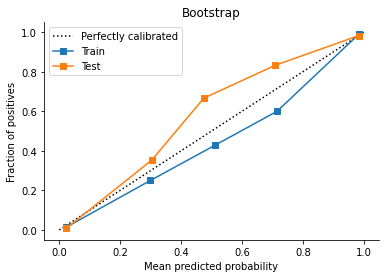

In [31]:
plot_caliberation_classification(bootstrap_pred_train,bootstrap_pred_test,title="Bootstrap")
#plt.savefig("Bootstrap caliberation.pdf")

In [32]:
bootstrap = []

for i in range(num_bootstraps):
    params = params_list[i]
    b =  model.apply(params,jnp.c_[xx.ravel(), yy.ravel()],deterministic=True).reshape(xx.shape)
    bootstrap.append(b)
bootstrap_mean = jnp.array(bootstrap).mean(axis=0)
bootstrap_sigma = jnp.sqrt(bootstrap_mean*(1-bootstrap_mean))

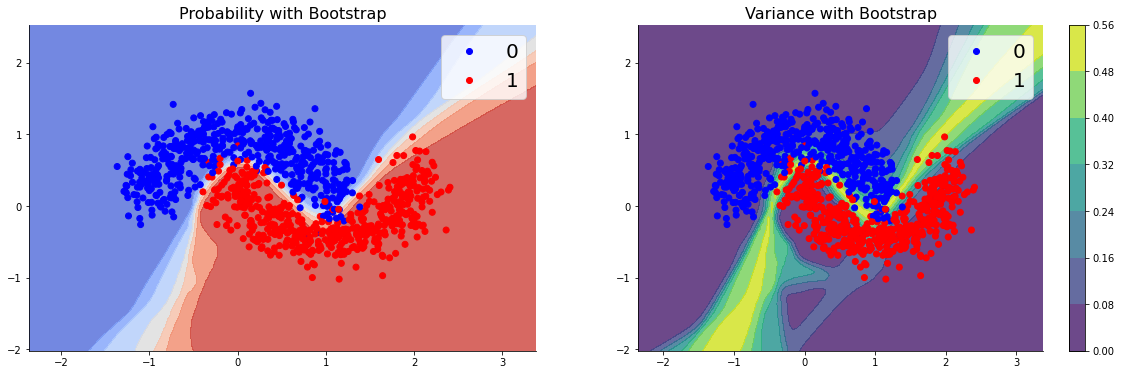

In [33]:
plot_binary_class(X,Y,xx,yy,bootstrap_mean,bootstrap_sigma,titles=("Probability with Bootstrap","Variance with Bootstrap"))
#plt.savefig("Bootstrap Moons.pdf")

# NUTS

In [34]:
def bnn_log_joint(params:dict, X, y, model):
    """
    computes the numerator term of the posterior funtion.

    params: dictionary initalized by model 
    X: shape-(n_samples,2) training points 
    y: shape-(n_samples,) labels for training points
    model: bnn model
    """
    
    logits = model.apply(params, X,deterministic=True).ravel()
    
    flatten_params, _ = ravel_pytree(params)
    log_prior = tfd.Normal(0.0, 1.0).log_prob(flatten_params).sum()
    log_likelihood = tfd.Bernoulli(logits=logits).log_prob(y).sum()
    log_joint = log_prior + log_likelihood
    return log_joint

bnn_log_joint_partial =partial(bnn_log_joint,X=X,y=Y,model=model)
bnn_log_joint_partial(params)

DeviceArray(-1869.6869, dtype=float32)

In [35]:
from pandas import read_pickle
states,infos = read_pickle("mcmc_moons.pkl")['states'],read_pickle("mcmc_moons.pkl")['infos']

In [37]:
num_warmup = 4000
potential = bnn_log_joint_partial
key = jax.random.PRNGKey(314)
key_samples, key_init, key_warmup, key = jax.random.split(key, 4)
adapt = blackjax.window_adaptation(blackjax.nuts, potential, num_warmup)
final_state, kernel, _ = adapt.run(key_warmup, params)
num_samples = 1000
states,infos = inference_loop(key_samples, kernel, final_state, num_samples)

In [39]:
from pandas import to_pickle
to_pickle({"states":states,"infos":infos},"mcmc_moons.pkl")

In [36]:
seed = jax.random.PRNGKey(0)

def predict_mcmc(x_test):
    def one_step(carry, state):
        params_cur = state.position
        samples = tfd.Bernoulli(probs=model.apply(params_cur,x_test,deterministic=True)).sample(seed=seed)
        return carry, samples
    _, y_stacks = jax.lax.scan(one_step, None, states)
    mean = y_stacks.mean(axis=0)
    std_dev = y_stacks.std(axis=0) 
    return mean,std_dev

mcmc_pred_mean,mcmc_pred_sigma = predict_mcmc(jnp.c_[xx.ravel(), yy.ravel()])
mcmc_pred_mean,mcmc_pred_sigma = mcmc_pred_mean.reshape(xx.shape),mcmc_pred_sigma.reshape(xx.shape)

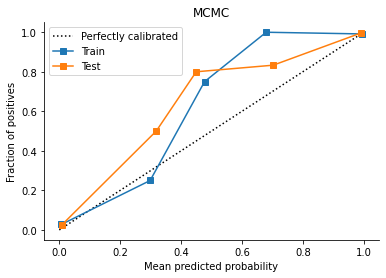

In [37]:
mcmc_pred_train, _= predict_mcmc(X_train)
mcmc_pred_test,_ = predict_mcmc(X_test)
plot_caliberation_classification(mcmc_pred_train,mcmc_pred_test,"MCMC")
#plt.savefig("MCMC_caliberation.pdf")

Text(0.5, 0.98, 'BNN using MCMC')

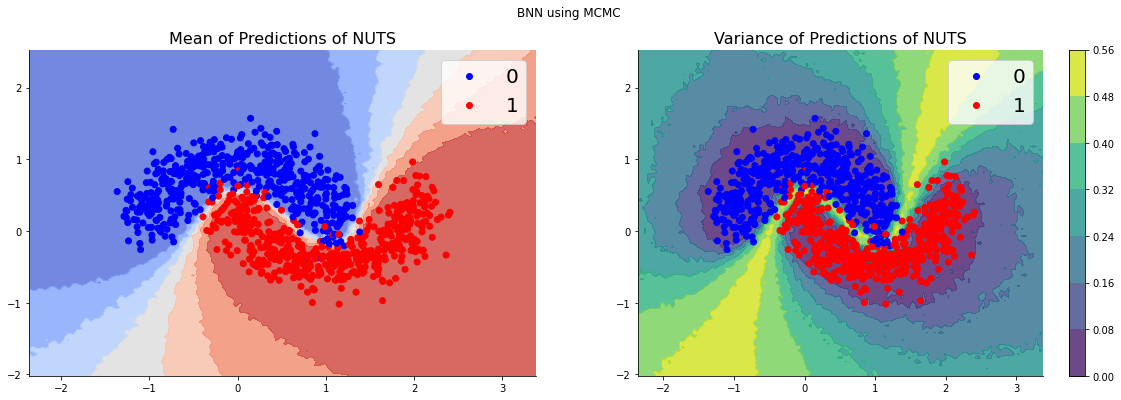

In [38]:
titles_mcmc = ("Mean of Predictions of NUTS","Variance of Predictions of NUTS")
plot_binary_class(X_scatters=X,y_scatters=Y,XX1_grid=xx,
XX2_grid = yy,grid_preds_mean=mcmc_pred_mean,grid_preds_sigma= mcmc_pred_sigma,titles=titles_mcmc)
plt.suptitle("BNN using MCMC")
#plt.savefig("MCMC_moons.pdf")

# GP

In [39]:
import GPy
import numpy as np
h=0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = jnp.meshgrid(jnp.arange(x_min, x_max, h),
                     jnp.arange(y_min, y_max, h))

model = GPy.models.GPClassification(np.array(X_train), np.array(y_train.reshape(-1,1)))
print(model)
print(model.log_likelihood())
model.optimize(messages=True)
model.optimize_restarts(num_restarts=5)
print(model)
model.plot_f()
probability_gp,na = model.predict(jnp.c_[xx.ravel(), yy.ravel()])


Name : gp_classification
Objective : 109.74521506350109
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |  value  |  constraints  |  priors
  rbf.variance        |    1.0  |      +ve      |        
  rbf.lengthscale     |    1.0  |      +ve      |        
-109.74521506350109


Optimization restart 1/5, f = 57.93500530643348
Optimization restart 2/5, f = 83.30246690068492
Optimization restart 3/5, f = 71.55189972834168
Optimization restart 4/5, f = 70.35021744208154
Optimization restart 5/5, f = 71.21832433256947

Name : gp_classification
Objective : 74.08720221786649
Number of Parameters : 2
Number of Optimization Parameters : 2
Updates : True
Parameters:
  gp_classification.  |               value  |  constraints  |  priors
  rbf.variance        |  13.753596896204424  |      +ve      |        
  rbf.lengthscale     |  0.7116821355206576  |      +ve      |        


 /home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'
 /home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning:Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.


In [ ]:
probability_gp = probability_gp.reshape(xx.shape)
sigma_gp = jnp.sqrt(probability_gp*(1-probability_gp)).reshape(xx.shape)


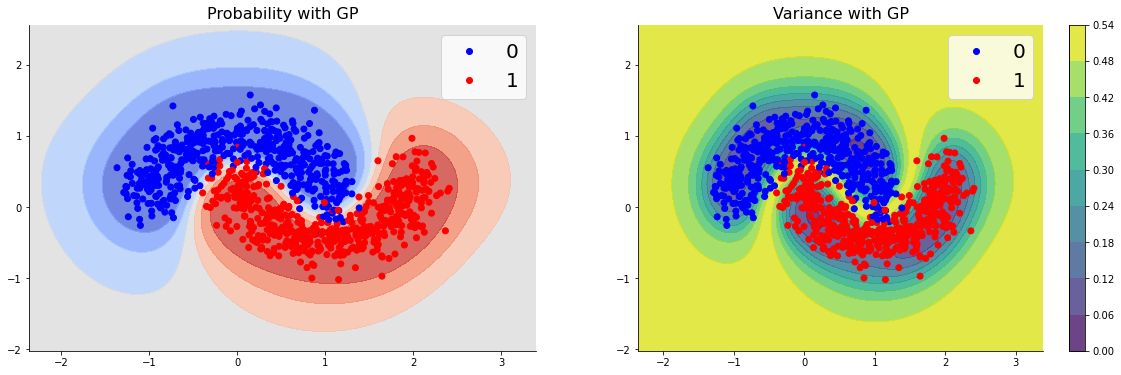

In [ ]:
plot_binary_class(X,Y,xx,yy,probability_gp,sigma_gp,titles=("Probability with GP","Variance with GP"))
#plt.savefig("GP moons.pdf")

 /home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning:Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.


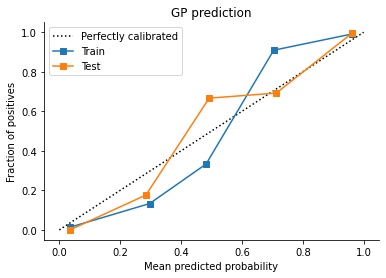

In [ ]:
gp_pred_train,na = model.predict(X_train)
gp_pred_test, na = model.predict(X_test)
plot_caliberation_classification(gp_pred_train,gp_pred_test,"GP prediction")
#plt.savefig("GP_caliberation.pdf")

# SNGP

In [ ]:
%pip install -qq tf-models-official

  Using cached tf_models_official-2.9.2-py2.py3-none-any.whl (2.1 MB)
  Using cached kaggle-1.5.12.tar.gz (58 kB)
  Preparing metadata (setup.py) ... done
  Using cached gin_config-0.5.0-py3-none-any.whl (61 kB)
  Using cached sentencepiece-0.1.96-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached sacrebleu-2.1.0-py3-none-any.whl (92 kB)
  Using cached pycocotools-2.0.4.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 415.2 kB/s eta 0:00:000:00:01m eta 0:00:01
  Using cached PyYAML-5.4.1-cp37-cp37m-manylinux1_x86_64.whl (636 kB)
  Using cached py-cpuinfo-8.0.0.tar.gz (99 kB)
  Preparing metadata (setup.py) ... done
  Using cached tensorflow_model_optimization-0.7.2-py2.py3-none-any.whl (237 kB)
  Using cached tf_slim-1.1.0-py2.py3-none-any.whl (352 kB)
  Using cached oauth2client-4.1.3-py2.py3-none-

In [47]:
import pkg_resources
import importlib
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/home/anand/anaconda3/envs/srip/lib/python3.7/site-packages/pkg_resources/__init__.py'>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sklearn.datasets

from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
try:
    import official.nlp.modeling.layers as nlp_layers
except ModuleNotFoundError:
    %pip install -qq tf-models-official
    import official.nlp.modeling.layers as nlp_layers

    

2022-07-02 11:50:26.708728: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-02 11:50:26.729856: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-02 11:50:26.729871: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [50]:
class DeepResNet(tf.keras.Model):
  """Defines a multi-layer residual network."""
  def __init__(self, num_classes, num_layers=3, num_hidden=128,
               dropout_rate=0.1, **classifier_kwargs):
    super().__init__()
    # Defines class meta data.
    self.num_hidden = num_hidden
    self.num_layers = num_layers
    self.dropout_rate = dropout_rate
    self.classifier_kwargs = classifier_kwargs

    # Defines the hidden layers.
    self.input_layer = tf.keras.layers.Dense(self.num_hidden, trainable=False)
    self.dense_layers = [self.make_dense_layer() for _ in range(num_layers)]

    # Defines the output layer.
    self.classifier = self.make_output_layer(num_classes)

  def call(self, inputs):
    # Projects the 2d input data to high dimension.
    hidden = self.input_layer(inputs)

    # Computes the resnet hidden representations.
    for i in range(self.num_layers):
      resid = self.dense_layers[i](hidden)
      resid = tf.keras.layers.Dropout(self.dropout_rate)(resid)
      hidden += resid

    return self.classifier(hidden)

  def make_dense_layer(self):
    """Uses the Dense layer as the hidden layer."""
    return tf.keras.layers.Dense(self.num_hidden, activation="relu")

  def make_output_layer(self, num_classes):
    """Uses the Dense layer as the output layer."""
    return tf.keras.layers.Dense(
        num_classes, **self.classifier_kwargs)

In [51]:
class DeepResNetSNGP(DeepResNet):
  def __init__(self, spec_norm_bound=0.9, **kwargs):
    self.spec_norm_bound = spec_norm_bound
    super().__init__(**kwargs)

  def make_dense_layer(self):
    """Applies spectral normalization to the hidden layer."""
    dense_layer = super().make_dense_layer()
    return nlp_layers.SpectralNormalization(
        dense_layer, norm_multiplier=self.spec_norm_bound)

  def make_output_layer(self, num_classes):
    """Uses Gaussian process as the output layer."""
    return nlp_layers.RandomFeatureGaussianProcess(
        num_classes, 
        gp_cov_momentum=-1,
        **self.classifier_kwargs)

  def call(self, inputs, training=False, return_covmat=False):
    # Gets logits and covariance matrix from GP layer.
    logits, covmat = super().call(inputs)

    # Returns only logits during training.
    if not training and return_covmat:
      return logits, covmat

    return logits

In [52]:
class ResetCovarianceCallback(tf.keras.callbacks.Callback):

  def on_epoch_begin(self, epoch, logs=None):
    """Resets covariance matrix at the beginning of the epoch."""
    if epoch > 0:
      self.model.classifier.reset_covariance_matrix()

In [53]:
class DeepResNetSNGPWithCovReset(DeepResNetSNGP):
  def fit(self, *args, **kwargs):
    """Adds ResetCovarianceCallback to model callbacks."""
    kwargs["callbacks"] = list(kwargs.get("callbacks", []))
    kwargs["callbacks"].append(ResetCovarianceCallback())

    return super().fit(*args, **kwargs)

In [54]:
def compute_posterior_mean_probability(logits, covmat, lambda_param=np.pi / 8.):
  # Computes uncertainty-adjusted logits using the built-in method.
  logits_adjusted = nlp_layers.gaussian_process.mean_field_logits(
      logits, covmat, mean_field_factor=lambda_param)

  return tf.nn.softmax(logits_adjusted, axis=-1)[:, 0]

In [55]:
DEFAULT_X_RANGE = (-3.5, 3.5)
DEFAULT_Y_RANGE = (-2.5, 2.5)
DEFAULT_N_GRID = 100


In [56]:
def make_training_data(sample_size=500):
  """Create two moon training dataset."""
  train_examples, train_labels = sklearn.datasets.make_moons(
      n_samples=2 * sample_size, noise=0.1)

  # Adjust data position slightly.
  train_examples[train_labels == 0] += [-0.1, 0.2]
  train_examples[train_labels == 1] += [0.1, -0.2]

  return train_examples, train_labels

def make_testing_data(x_range=DEFAULT_X_RANGE, y_range=DEFAULT_Y_RANGE, n_grid=DEFAULT_N_GRID):
  """Create a mesh grid in 2D space."""
  # testing data (mesh grid over data space)
  x = np.linspace(x_range[0], x_range[1], n_grid)
  y = np.linspace(y_range[0], y_range[1], n_grid)
  xv, yv = np.meshgrid(x, y)
  return np.stack([xv.flatten(), yv.flatten()], axis=-1),xv,yv

X_train,y_train = make_training_data(
    sample_size=500)

X_test,xx,yy = make_testing_data()

In [57]:
def train_and_test_sngp(X_train, X_test):
  sngp_model = DeepResNetSNGPWithCovReset(**resnet_config)

  sngp_model.compile(**train_config)
  sngp_model.fit(X_train, np.array(y_train), verbose=0, **fit_config)

  sngp_logits, sngp_covmat = sngp_model(X_test, return_covmat=True)
  sngp_probs = compute_posterior_mean_probability(sngp_logits, sngp_covmat)

  return sngp_probs

In [58]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy(),
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
resnet_config = dict(num_classes=2, num_layers=6, num_hidden=128)
train_config = dict(loss=loss, metrics=metrics, optimizer=optimizer)
fit_config = dict(batch_size=128, epochs=1000)

2022-07-02 11:17:18.439919: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-02 11:17:18.439951: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [59]:
X_train.shape

(1000, 2)

In [60]:
import numpy as np
sngp_probs = train_and_test_sngp(np.array(X_train), X_test)

In [61]:
sngp_std = np.sqrt(sngp_probs*(1-sngp_probs))

In [62]:
sngp_probs = jnp.array(sngp_probs).reshape(xx.shape)

In [63]:
sngp_std = jnp.array(sngp_std).reshape(xx.shape)

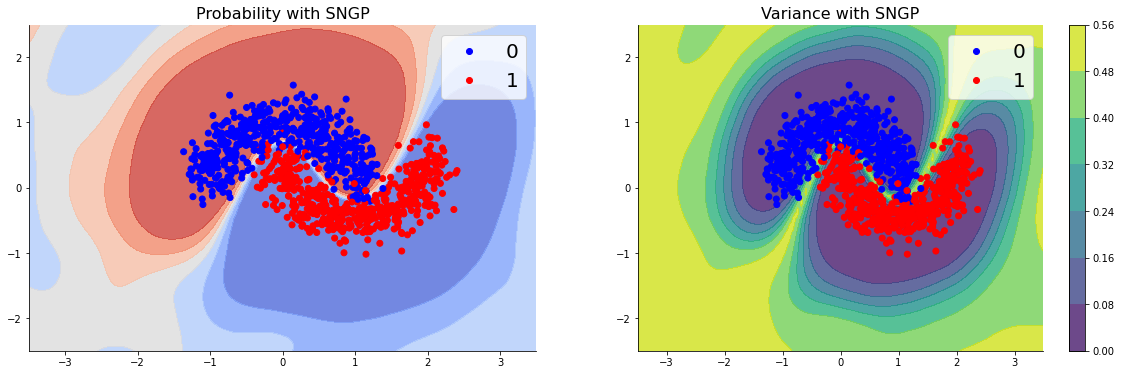

In [64]:
plot_binary_class(X,Y,xx,yy,sngp_probs,sngp_std,titles=("Probability with SNGP","Variance with SNGP"))


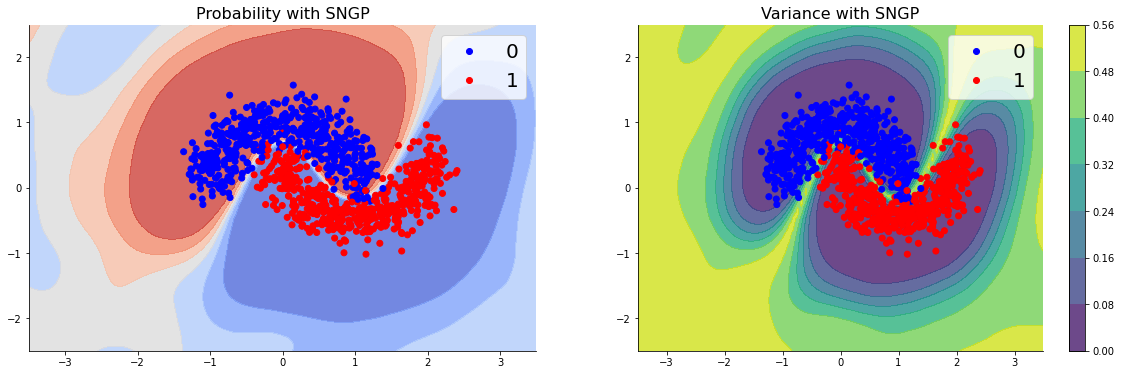

In [68]:
plot_binary_class(X,Y,xx,yy,sngp_probs,sngp_std,titles=("Probability with SNGP","Variance with SNGP"))


In [65]:
sngp_pred_train = train_and_test_sngp(np.array(X_train), X_train)

In [ ]:
# sngp_pred_test = train_and_test_sngp(np.array(X_train), X_train)

In [66]:
def plot_caliberation_classification(pred_train,pred_test,title):
    fig,ax1 = plt.subplots(1,1)
    prob_true_train,prob_pred_train = calibration_curve(y_train,pred_train,n_bins=5)
    # prob_true_test,prob_pred_test = calibration_curve(y_train,pred_test)

    disp_train = CalibrationDisplay(prob_true_train,prob_pred_train,pred_train,estimator_name="Train")
    # disp_test = CalibrationDisplay(prob_true_test,prob_pred_test,pred_test,estimator_name="Test",)

    disp_train.plot(ax=ax1)
    # disp_test.plot(ax=ax1)
    sns.despine(ax=ax1)
    ax1.legend(loc=0)
    ax1.set_title(title)

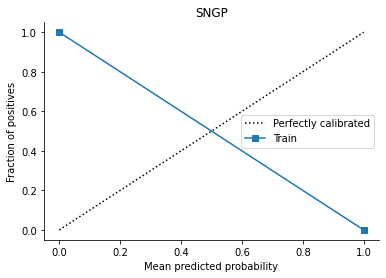

In [67]:
plot_caliberation_classification(sngp_pred_train,sngp_pred_train,"SNGP")